In [1]:
#Paso 1: Lectura
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#Import sklearn libraries
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

%matplotlib inline

#Path where database is located
excel_path = 'datos/DataBase2012.xlsx'

#Reading database
Xdata = pd.read_excel(excel_path)

#Selecting variables of interest
#'SPPB_TOTAL_imp'= Real value of SPPB
xnew = Xdata[['CODE_sit','SPPB_TOTAL_imp', 'FES_sum_imputed','CBS_sum_imp', 'NAGI','SPPB_CHA_imp', 'SPPB_BAL_imp','SPPB_GAIT_imp']]

In [2]:
#Deleting registers with null values
for i in xnew.columns:
    xnew[i] = pd.to_numeric(xnew[i],errors='coerce')
print(xnew.isnull().sum())
xnew.dropna(inplace=True)

#Calculating SPPB_Calculated according to best linear regression models obtained by site
#'CODE_sit' = 1 Kingston
#'CODE_sit' = 2 Saint-Hyacinthe
#'CODE_sit' = 3 Tirana
#'CODE_sit' = 4 Manizales
#'CODE_sit' = 5 Natal
xnew['SPPB_Calculated'] = np.where(xnew['CODE_sit']==1, (2.157+1.265*xnew['SPPB_BAL_imp']+1.227*xnew['SPPB_CHA_imp']) , 0)
xnew['SPPB_Calculated'] = np.where(xnew['CODE_sit']==2, (3.316+1.059*xnew['SPPB_BAL_imp']+1.103*xnew['SPPB_CHA_imp']), xnew['SPPB_Calculated'] )
xnew['SPPB_Calculated'] = np.where(xnew['CODE_sit']==3, (1.179+1.450*xnew['SPPB_BAL_imp']+1.193*xnew['SPPB_CHA_imp']), xnew['SPPB_Calculated'] )
xnew['SPPB_Calculated'] = np.where(xnew['CODE_sit']==4, (1.867+1.236*xnew['SPPB_BAL_imp']+1.292*xnew['SPPB_CHA_imp']), xnew['SPPB_Calculated'] )
xnew['SPPB_Calculated'] = np.where(xnew['CODE_sit']==5, (2.031+1.147*xnew['SPPB_BAL_imp']+1.276*xnew['SPPB_CHA_imp']), xnew['SPPB_Calculated'] )
  

CODE_sit            0
SPPB_TOTAL_imp      4
FES_sum_imputed    10
CBS_sum_imp        47
NAGI                9
SPPB_CHA_imp        4
SPPB_BAL_imp        4
SPPB_GAIT_imp       4
dtype: int64


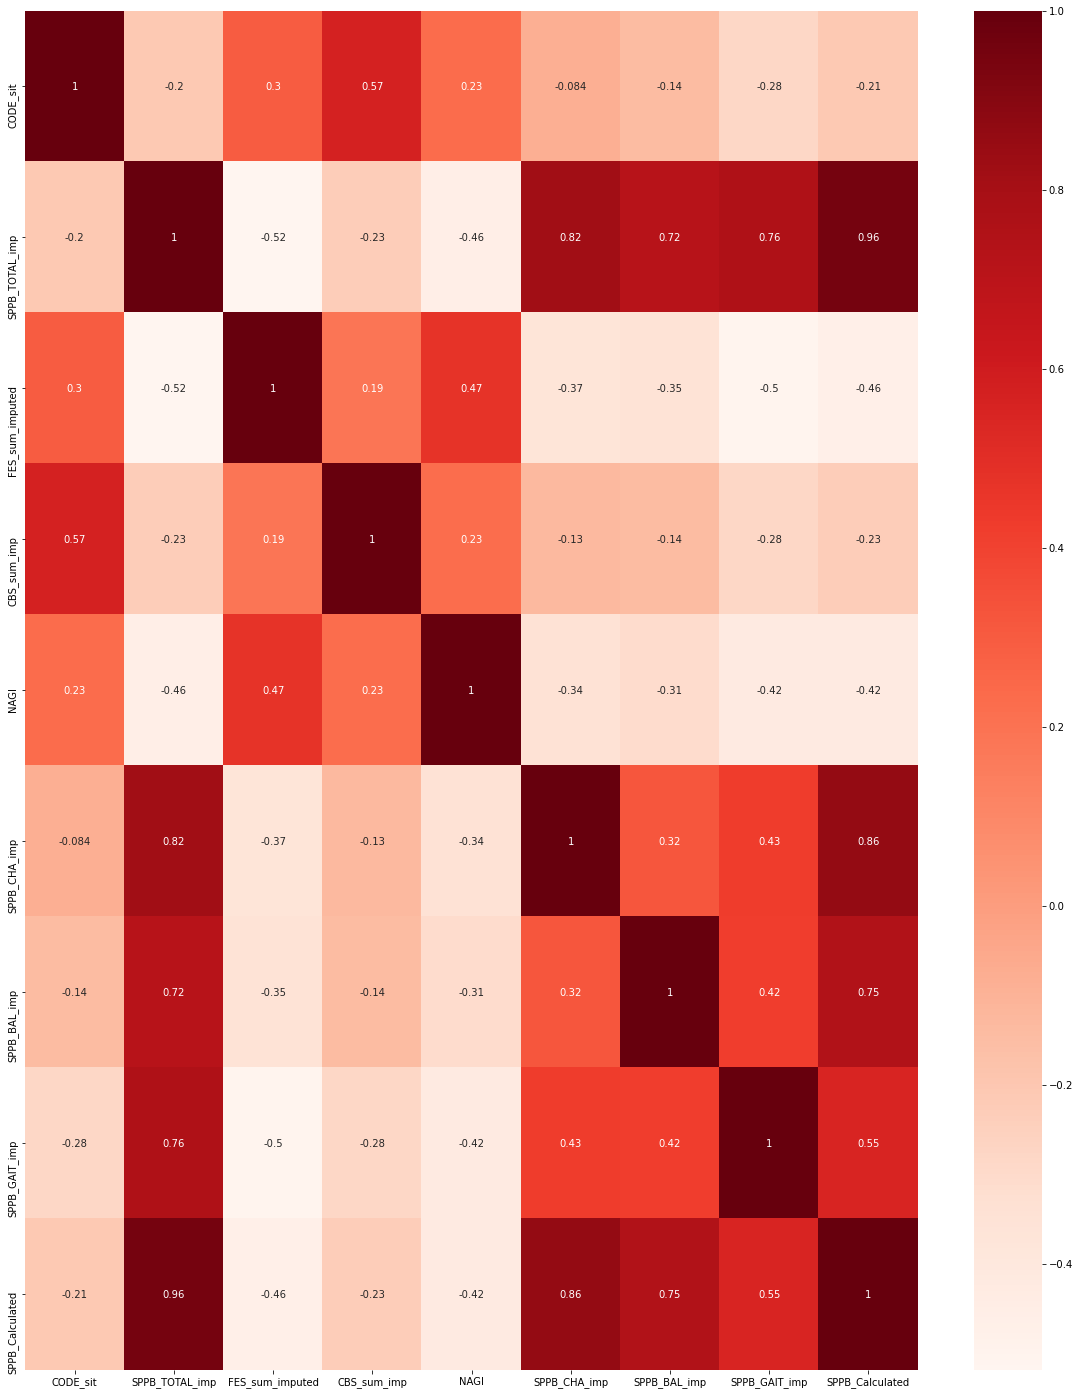

In [3]:
#Ploting correlation between all variables
import seaborn as sns
plt.figure(figsize=(20,25))
cor = xnew.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Random Forest analysis

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Selecting variables to train model - Using SPPBOriginal = 'SPPB_TOTAL_imp'
X_SPPBOriginal = xnew[['CODE_sit','SPPB_TOTAL_imp', 'FES_sum_imputed','CBS_sum_imp', 'NAGI']]

#Splitting data into training and testing portions
train_set, test_set = train_test_split(X_SPPBOriginal, test_size=0.2, random_state=42)

#Defining FES variables as the explained variable
variable_explained = "FES_sum_imputed"

#Selecting which variables are predictor and predicted in each portion
ytrain = train_set[variable_explained]
Xtrain = train_set.drop(variable_explained, axis=1)
ytest = test_set[variable_explained]
Xtest = test_set.drop(variable_explained, axis=1)

In [5]:
#Importing Random Forest algorithm
from sklearn.ensemble import RandomForestRegressor

#RandomForest parameters
steps=[('reg', RandomForestRegressor())]
parameters = {'reg__max_depth' : [2,3,4,5,6,7,8,10,12],
              'reg__n_estimators' : [2,4,6,8,10,20,40,60,70,80,90,100,110,120,130,140],
              }

#Configuration of pipeline
pipeline = Pipeline(steps = steps)
grid_search = GridSearchCV(pipeline, parameters, n_jobs=6,cv=5,
                           scoring='neg_mean_absolute_error',
                           verbose=10)

#Executing training of model
grid_search.fit(Xtrain, ytrain.tolist())

#Best training model
lin_reg = grid_search.best_estimator_
lin_reg.get_params

Fitting 5 folds for each of 144 candidates, totalling 720 fits


<bound method Pipeline.get_params of Pipeline(steps=[('reg', RandomForestRegressor(max_depth=4, n_estimators=40))])>

## SPPBOriginal Analysis

[2.35491956e-01 3.58674931e+00 1.33753766e+00 1.76450804e+00
 2.93864537e-01 4.23549196e+00 1.45842758e+01 1.38825025e+00
 1.40125395e-02 1.23882502e+01 1.26725847e+01 8.48448884e-01
 6.76450804e+00 1.15155112e+00 1.34205437e+01 1.76450804e+00
 1.84844888e+00 3.44921749e+00 8.48448884e-01 1.51551116e-01
 1.84844888e+00 2.39513901e+01 3.41421284e+00 5.32741528e+00
 1.61952889e+00 1.98598746e+00 1.98428056e+00 9.26627342e+00
 1.69628824e+00 2.99836861e+00 1.65842758e+01 2.48781177e+00
 4.49217493e-01 5.59614502e+00 3.38825025e+00 1.38844036e+01
 2.38047111e+00 2.55078251e+00 9.11200987e+00 8.52041335e+00
 1.84844888e+00 4.05179770e-01 1.34719846e+00 3.23173513e+00
 1.51551116e-01 2.54659219e+00 1.09716642e+01 4.70613546e+00
 4.49217493e-01 6.96288241e-01 2.76450804e+00 4.78853914e+00
 1.63705738e+00 2.33753766e+00 3.23471966e-01 3.61174975e+00
 1.65421326e+01 2.33753766e+00 1.84844888e+00 7.51218823e+00
 1.54659219e+00 7.64508044e-01 4.61174975e+00 5.04860987e+00
 1.84844888e+00 3.235491

<function matplotlib.pyplot.show(close=None, block=None)>

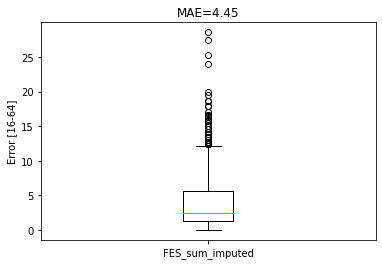

In [6]:
from sklearn.metrics import mean_squared_error

#Obtaining predictions acording to model trained
predictions = lin_reg.predict(Xtest)

#Vector with errors obtained of testing model with SPPB Original
vmaeOriginal = mean_absolute_error(np.array(ytest).reshape(1,-1),np.array(predictions).reshape(1,-1),multioutput='raw_values')

#Ploting boxplot and showing MAE
plt.boxplot(vmaeOriginal)
print(vmaeOriginal)
plt.xticks([1],labels=['FES_sum_imputed'])
plt.ylabel('Error [16-64]')
plt.title('MAE=%.2f'% mean_absolute_error(ytest,predictions))
plt.show

## SPPB Calculated Analyisis

In [7]:
#Selecting variables to testing model - Using SPPBCalculated = 'SPPB_Calculated'
X_SPPBCalculated = xnew[['CODE_sit','SPPB_Calculated', 'FES_sum_imputed','CBS_sum_imp', 'NAGI']]

#Splitting data again, but now using SPPB_Calculated variable. Due we use he same randome_state, partition will be the same.
train_set, test_set = train_test_split(X_SPPBCalculated, test_size=0.2, random_state=42)
variable_explained = "FES_sum_imputed"

ytrain = train_set[variable_explained]
Xtrain = train_set.drop(variable_explained, axis=1)
ytest = test_set[variable_explained]
Xtest = test_set.drop(variable_explained, axis=1)


[2.35491956e-01 3.58674931e+00 1.83204355e+00 1.76450804e+00
 2.93864537e-01 4.23549196e+00 1.45842758e+01 1.38825025e+00
 1.40125395e-02 1.23882502e+01 1.54795866e+01 8.48448884e-01
 6.76450804e+00 1.15155112e+00 2.13882502e+01 1.76450804e+00
 1.84844888e+00 3.44921749e+00 8.48448884e-01 1.51551116e-01
 1.84844888e+00 2.39513901e+01 3.41421284e+00 2.52041335e+00
 1.61952889e+00 1.84844888e+00 1.87110925e+00 9.26627342e+00
 1.69628824e+00 1.98164769e+00 1.65842758e+01 2.48781177e+00
 4.49217493e-01 5.79251724e+00 3.38825025e+00 7.67792439e+00
 2.38047111e+00 2.55078251e+00 9.11200987e+00 1.09080589e+01
 1.84844888e+00 4.05179770e-01 2.61895652e-01 3.23173513e+00
 1.51551116e-01 2.54659219e+00 8.21146086e+00 4.70613546e+00
 4.49217493e-01 6.96288241e-01 2.76450804e+00 4.78853914e+00
 5.54549841e+00 2.83204355e+00 3.23471966e-01 4.04860987e+00
 1.68160118e+01 2.83204355e+00 1.84844888e+00 7.51218823e+00
 2.29386454e+00 7.64508044e-01 5.04860987e+00 4.61174975e+00
 1.84844888e+00 3.235491

<function matplotlib.pyplot.show(close=None, block=None)>

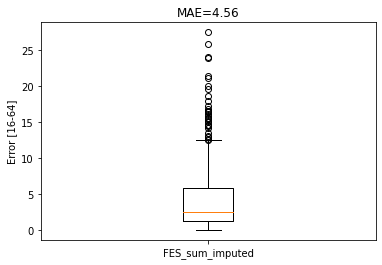

In [8]:
#Obtaining predictions acording to model trained
predictions = lin_reg.predict(Xtest)

#Vector with errors obtained of testing model with SPPB Calculated
vmaeCalculated = mean_absolute_error(np.array(ytest).reshape(1,-1),np.array(predictions).reshape(1,-1),multioutput='raw_values')
print(vmaeCalculated)

#Ploting boxplot and showing MAE
plt.boxplot(vmaeCalculated)
plt.xticks([1],labels=['FES_sum_imputed'])
plt.ylabel('Error [16-64]')
plt.title('MAE=%.2f'% mean_absolute_error(ytest,predictions))
plt.show

## Means comparison of MAE

In [9]:
#Importing Mann Whitney library
from scipy.stats import mannwhitneyu

#Calculating pValue of Mann Whitney Test
mannwhitneyu(vmaeOriginal, vmaeCalculated)

MannwhitneyuResult(statistic=74090.5, pvalue=0.3082512700398116)

# Decision Tree

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Selecting variables to train model - Using SPPBOriginal = 'SPPB_TOTAL_imp'
X_SPPBOriginal = xnew[['CODE_sit','SPPB_TOTAL_imp', 'FES_sum_imputed','CBS_sum_imp', 'NAGI']]

#Splitting data into train and test portions
train_set, test_set = train_test_split(X_SPPBOriginal, test_size=0.2, random_state=42)

#Defining FES variables as the explained variable
variable_explained = "FES_sum_imputed"

#Selecting wich variables are predictives and predictes in each portion
ytrain = train_set[variable_explained]
Xtrain = train_set.drop(variable_explained, axis=1)
ytest = test_set[variable_explained]
Xtest = test_set.drop(variable_explained, axis=1)

In [11]:
#Importing Decision Tree algorithm
from sklearn.tree import DecisionTreeRegressor


steps=[('reg', DecisionTreeRegressor())]

#DecisionTree
parameters = {'reg__max_depth' : [2,3,5,6,7,8,9,10,12],
              'reg__min_samples_split' : [2,3,4,5,6,7,8,9,10]}

#Configuration of pipeline
pipeline = Pipeline(steps = steps)
grid_search = GridSearchCV(pipeline, parameters, n_jobs=6,cv=5,
                           scoring='neg_mean_absolute_error',
                           verbose=10)

#Executing training of model
grid_search.fit(Xtrain, ytrain.tolist())

#Best training model
lin_reg = grid_search.best_estimator_
lin_reg.get_params

Fitting 5 folds for each of 81 candidates, totalling 405 fits


<bound method Pipeline.get_params of Pipeline(steps=[('reg', DecisionTreeRegressor(max_depth=3))])>

## SPPB Original - DT

[ 1.03571429  2.13675214  1.13675214  0.96428571  1.1641791   5.03571429
 15.89047619  2.8358209   0.41762452 13.8358209  13.21323529  1.41762452
  5.96428571  0.58237548 12.21323529  0.96428571  2.41762452  5.26162791
  1.41762452  0.41762452  2.41762452 25.8358209   2.41762452  4.78676471
  2.58237548  2.41762452  2.89047619 10.78676471  2.58237548  3.10952381
 17.89047619  3.13675214  2.26162791  3.78676471  4.8358209  16.92592593
  1.41762452  0.73837209  5.26162791  7.10952381  2.41762452  1.58237548
  0.13675214  2.41762452  0.41762452  1.8358209   9.73837209  6.1641791
  2.26162791  1.58237548  1.96428571  3.26162791  0.96428571  2.13675214
  0.13675214  2.1641791  17.21323529  2.13675214  2.41762452  6.86324786
  0.8358209   0.03571429  3.1641791   3.1641791   2.41762452  4.03571429
  1.41762452  0.41762452  5.96428571  3.58237548  7.26162791  0.58237548
  2.21323529  2.03571429  7.1641791   2.8358209   5.03571429 11.10952381
  4.03571429  0.41762452  2.41762452  1.26162791  2.

<function matplotlib.pyplot.show(close=None, block=None)>

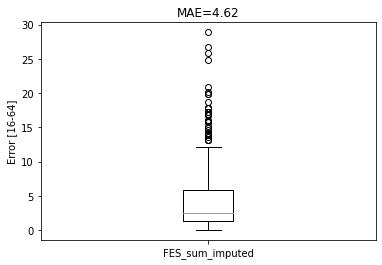

In [12]:
#Obtaining predictions acording to model trained
predictions = lin_reg.predict(Xtest)

#Vector with errors obtained of testing model with SPPB Original
vmaeOriginal = mean_absolute_error(np.array(ytest).reshape(1,-1),np.array(predictions).reshape(1,-1),multioutput='raw_values')

#Ploting boxplot and showing MAE
plt.boxplot(vmaeOriginal)
print(vmaeOriginal)
plt.xticks([1],labels=['FES_sum_imputed'])
plt.ylabel('Error [16-64]')
plt.title('MAE=%.2f'% mean_absolute_error(ytest,predictions))
plt.show

## SPPB Calculated - DT

In [13]:
#Selecting variables to testing model - Using SPPBCalculated = 'SPPB_Calculated'
X_SPPBCalculated = xnew[['CODE_sit','SPPB_Calculated', 'FES_sum_imputed','CBS_sum_imp', 'NAGI']]

#Splitting data again, but now using SPPB_Calculated variable. Due we use he same randome_state, partition will be the same.
train_set, test_set = train_test_split(X_SPPBCalculated, test_size=0.2, random_state=42)
variable_explained = "FES_sum_imputed"

ytrain = train_set[variable_explained]
Xtrain = train_set.drop(variable_explained, axis=1)
ytest = test_set[variable_explained]
Xtest = test_set.drop(variable_explained, axis=1)

[ 1.03571429  2.13675214  1.13675214  0.96428571  1.1641791   5.03571429
 15.89047619  2.8358209   0.41762452 13.8358209  16.89047619  1.41762452
  5.96428571  0.58237548 22.8358209   0.96428571  2.41762452  5.26162791
  1.41762452  0.41762452  2.41762452 25.8358209   2.41762452  1.10952381
  2.58237548  2.41762452  2.89047619 10.78676471  2.58237548  3.10952381
 17.89047619  3.13675214  2.26162791  3.78676471  4.8358209   5.78676471
  1.41762452  0.73837209  5.26162791 10.78676471  2.41762452  1.58237548
  0.13675214  2.41762452  0.41762452  1.8358209   9.73837209  6.1641791
  2.26162791  1.58237548  1.96428571  3.26162791  0.96428571  2.13675214
  0.13675214  2.1641791  17.21323529  2.13675214  2.41762452  6.86324786
  0.8358209   0.03571429  3.1641791   3.1641791   2.41762452  4.03571429
  1.41762452  0.41762452  5.96428571  3.58237548  7.26162791  0.58237548
  2.21323529  2.03571429  7.1641791   2.8358209   5.03571429 11.10952381
  4.03571429  0.41762452  2.41762452  1.26162791  2.

<function matplotlib.pyplot.show(close=None, block=None)>

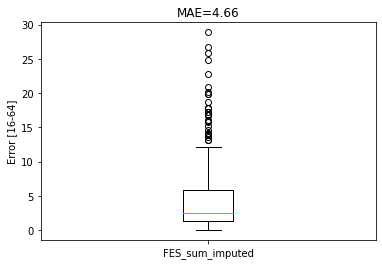

In [14]:
#Obtaining predictions acording to model trained
predictions = lin_reg.predict(Xtest)

#Vector with errors obtained of testing model with SPPB Calculated
vmaeCalculated = mean_absolute_error(np.array(ytest).reshape(1,-1),np.array(predictions).reshape(1,-1),multioutput='raw_values')
print(vmaeCalculated)
plt.boxplot(vmaeCalculated)

#Ploting boxplot and showing MAE
plt.xticks([1],labels=['FES_sum_imputed'])
plt.ylabel('Error [16-64]')
plt.title('MAE=%.2f'% mean_absolute_error(ytest,predictions))
plt.show

## Means comparison of MAE - DT

In [15]:
#Importing Mann Whitney library
from scipy.stats import mannwhitneyu

#Calculating pValue of Mann Whitney Test
mannwhitneyu(vmaeOriginal, vmaeCalculated)

MannwhitneyuResult(statistic=75012.5, pvalue=0.4181112008744814)